# Задача 2. Линейная регрессия, метод градиентного спуска

* **Дедлайн**: 29.10.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- При обучении моделей использовать **масштабирование данных**.
- Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- Повторить тоже самое, но используя **кросс-валидацию**.
- Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.
- (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.


In [1053]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%precision %.4f

import warnings
warnings.filterwarnings('ignore')

np.random.seed(69)


### Выбор и анализ данных

В качестве данных, был выбран датасет, который содержит данные об автомобилях. Целевым признакоя для предсказания является стоимость автомобиля.

In [1054]:
data_path = "../data/car_price/car_price.csv"
df = pd.read_csv(data_path, index_col=0)
df.head(3)


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0


### Подготовка данных

Итоговые признаки:
* `car_ID` --- идентификатор авто
* `symboling` --- рейтинг страхового риска
* `CarName` --- название авто
* `fueltype` --- тип топлива
* `aspiration` --- наличие модификации для аспирации двигателя
* `doornumber` --- количество дверей
* `carbody` --- тип авто
* `drivewheel` --- привод
* `enginelocation` --- расположение двигателя
* `wheelbase` ---  длина колёсной базы
* `carlenght` --- длина авто
* `carwidth` --- ширина авто
* `curbweight` --- высота авто
* `enginetype` --- тип двигателя
* `cylindernumber` --- количество цилиндров
* `enginesize` --- объём двигателя
* `fuelsystem` --- топливная система
* `boreratio` --- диаметр цилиндра
* `stroke` --- полный ход поршня по цилиндру в любом направлении
* `compessionratio` --- коэффициент сжатия
* `horsepower` ---  количество лошадиных сил
* `peakrpm` --- количество пиковых оборотов в минуту
* `citympg` --- расход в городе (миль/галон)
* `highwaympg` --- расход на трассе (миль/галон)
* `price` --- цена (целевой)

Идентификатор автомобиля `car_ID` используется в качестве идентификатора для `DataFrame`'а.

Сделаем минорное изменение для того, чтобы обеспечить согласованность названий признаков:

In [1055]:
df.rename_axis('id', inplace=True)
df.rename(columns={'CarName': 'carname'}, inplace=True)


В датасете нет необходимости выполнять чистку данных, так как датасет не содержит пропущенных значений, несогласованных значений признаков и т.п.

In [1056]:
print(f"Total number of null values: {df.isna().sum().sum()}.")


Total number of null values: 0.


Удалим признак `carname`, так как мы не сможем далее использовать информацию о названии конкретного автомобиля.

In [1057]:
df.drop(columns=['carname'], inplace=True)


### Разведочный анализ

In [1058]:
df.groupby('enginelocation').aggregate({'price':'mean'}).rename(columns={'price':'mean_price'})


,mean_price
enginelocation,
front,12961.097361
rear,34528.000000


Положение двигателя значительно влияет на стоимость, так как заднее расположение двигателей характерно для спортивных автомобилей.

In [1059]:
df.groupby(['carbody', 'enginelocation'])['carbody','enginelocation','price'].aggregate({'enginelocation':'count','price': 'mean'})\
  .rename(columns={'enginelocation':'count'})


count         price
carbody     enginelocation                     
convertible front               5  18863.000000
            rear                1  37028.000000
hardtop     front               6  18518.666667
            rear                2  33278.000000
hatchback   front              70  10376.652386
sedan       front              96  14344.270833
wagon       front              25  12371.960000

Действительно, заднее расположение двигателя встречается только у кабриолетов и автомобилей с "жёстким верхом", которые обычно являются спортивными.
Также можно сделать вывод о том, что самые доступные авто - это "hatchback" и с передним расположением двигателей.

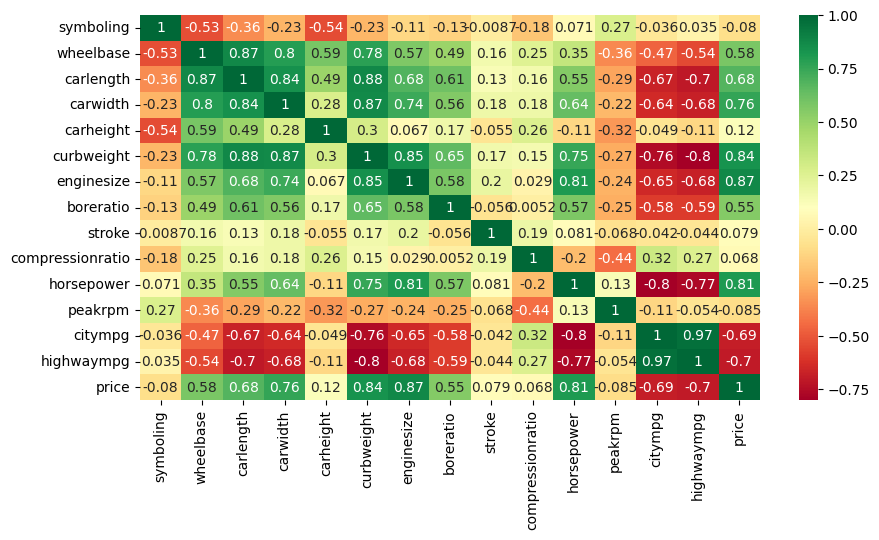

In [1060]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


Можно заметить, что в среднем признаки имеют высокую корреляцию.

Наиболее интересной для нас является цена, но также представлены признаки, значения корреляции для которых оказалось неожиданно низким. Таких признаков несколько: *symboling*, *carheight*, *stroke*, *compressionratio*. Отсутствие корреляции с первым свойством контринтуитивно, поскольку разумно предположить, что рейтинг страхового риска должен соответствовать цене авто (чем больше цена авто, тем меньше рейтинг). Однако это утверждение неверно исходя из представленных данных.

Также отсутствует зависимость цены от высоты авто, от хода цилиндра и коэффициента сжатия.

In [1061]:
df.drop(columns=['symboling', 'carheight', 'stroke', 'compressionratio'])


,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,peakrpm,citympg,highwaympg,price
id,,,,,,,,,,,,,,,,,,,,
1,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,2548,dohc,four,130,mpfi,3.47,111,5000,21,27,13495.0
2,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,2548,dohc,four,130,mpfi,3.47,111,5000,21,27,16500.0
3,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,2823,ohcv,six,152,mpfi,2.68,154,5000,19,26,16500.0
4,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,2337,ohc,four,109,mpfi,3.19,102,5500,24,30,13950.0
5,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,2824,ohc,five,136,mpfi,3.19,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,2952,ohc,four,141,mpfi,3.78,114,5400,23,28,16845.0
202,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,3049,ohc,four,141,mpfi,3.78,160,5300,19,25,19045.0
203,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,3012,ohcv,six,173,mpfi,3.58,134,5500,18,23,21485.0


### Трансформация данных

Преобразуем категориальные признаки:

In [1062]:
def map_values(df, column, values):
    mapping = {value: index for index, value in enumerate(values)}
    df[column] = df[column].map(mapping)

map_values(df, 'fueltype', ["gas", "diesel"])
map_values(df, 'aspiration', ['std', 'turbo'])
map_values(df, 'doornumber', ['two', 'four'])
map_values(df, 'carbody', ['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'])
map_values(df, 'drivewheel', ['rwd', '4wd', 'fwd'])
map_values(df, 'enginelocation', ['front', '4wd', 'rear'])
map_values(df, 'enginetype', ['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf', 'dohcv'])
map_values(df, 'cylindernumber', ['four', 'six', 'five', 'two', 'three', 'twelve', 'eight'])
map_values(df, 'fuelsystem', ['mpfi', '2bbl', '1bbl', '4bbl', 'idi', 'spdi', 'mfi', 'spfi'])

df.head(3)


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
id,,,,,,,,,,,,,,,,,,,,,
1,3,0,0,0,0,0,0,88.6,168.8,64.1,...,130,0,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,0,0,0,0,0,0,88.6,168.8,64.1,...,130,0,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,0,0,0,1,0,0,94.5,171.2,65.5,...,152,0,2.68,3.47,9.0,154,5000,19,26,16500.0


### Обновлённая корреляционная матрица

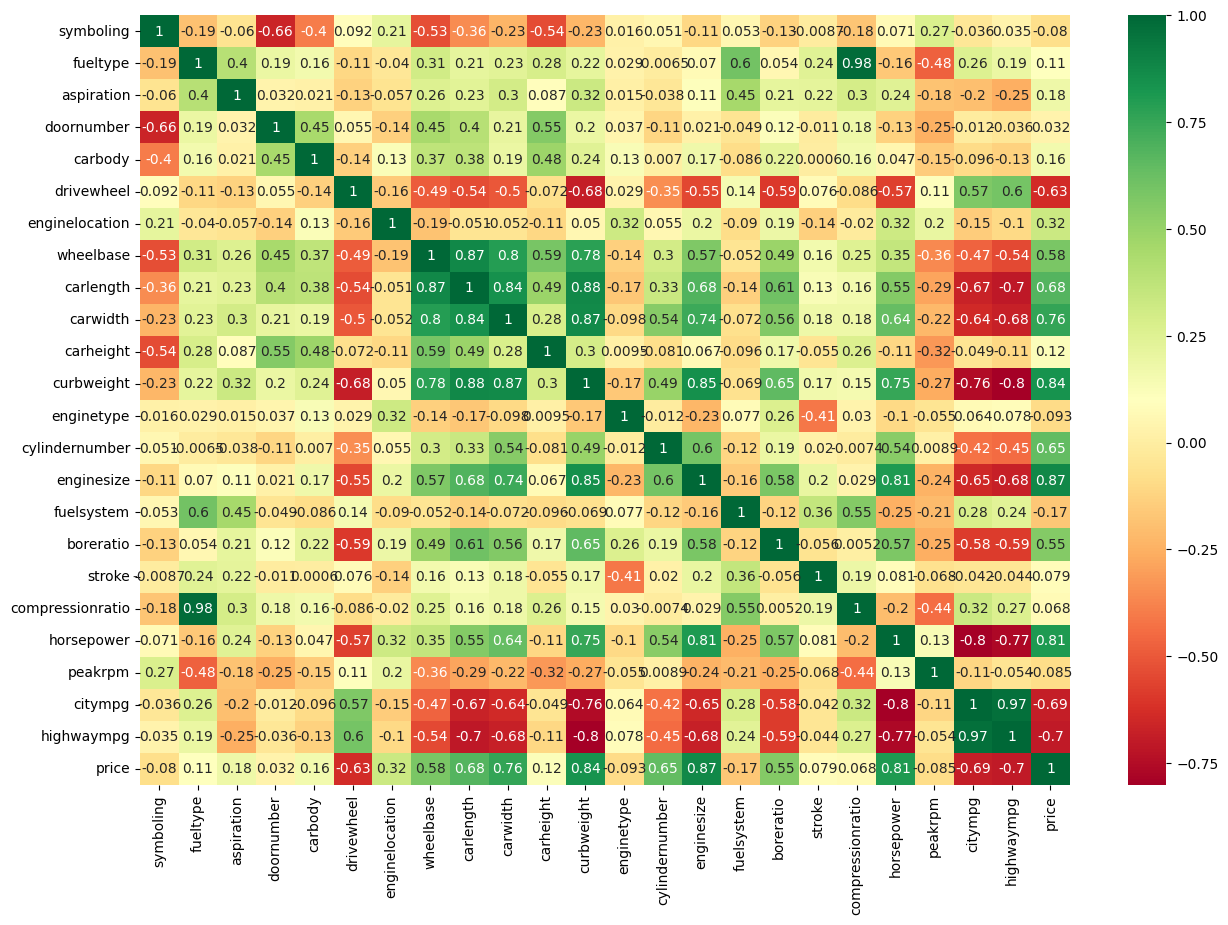

In [1063]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
plt.show()


### Выбор наилучшего подмножества признаков

Recursive Feature Elimination (RFE)

In [1064]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

X = df.drop(columns=['price'])
y = df['price']

rfecf = RFECV(
    estimator=Pipeline([("scaler", StandardScaler()), ("regressor", Ridge())]),
    importance_getter=lambda x: x.named_steps["regressor"].coef_
)

rfecv.fit(X, y)

interesting_features = list(X.columns[rfecv.support_])
print(f"Оптимальное количество признаков {rfecv.n_features_} ({interesting_features})")



Оптимальное количество признаков 5 (['enginelocation', 'carwidth', 'curbweight', 'cylindernumber', 'enginesize'])


Удалим остальные признаки:

In [1065]:
df = df[interesting_features]
df.head(3)


,enginelocation,carwidth,curbweight,cylindernumber,enginesize
id,,,,,
1,0,64.1,2548,0,130
2,0,64.1,2548,0,130
3,0,65.5,2823,1,152


### Реализация функций градиентного спуска

In [1066]:
import random

def gradient_descent(X, y, alpha=1, lambda_value=1E-3, epsilon=1E-2):
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    W = np.random.randn(n + 1)

    cost_prev = -1
    while True:
        y_estimated = X.dot(W)
        error = y_estimated - y
        L2_reg_term = alpha * np.sum(np.square(W[1:]))
        cost_curr = (1 / n) * np.sum(error ** 2) + L2_reg_term
        gradient = (1 / m) * (X.T.dot(error) + (alpha * W))
        W = W - lambda_value * gradient

        if abs(cost_curr - cost_prev) < epsilon:
            break

        cost_prev = cost_curr
    return W

def stohastic_gradient_descent(X, y, alpha=1, lambda_value=0.001, epsilon=1E-2, epochs=1000):
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    W = np.random.randn(n + 1).reshape(n + 1, 1)

    for _ in range(epochs):
        for i in range(m):
            random_index = np.random.randint(0, m)
            X_i = X[random_index, :].reshape(1, n + 1)
            y_i = y[random_index].reshape(1, 1)

            y_estimated = X_i.dot(W)
            error = y_estimated - y_i

            gradient = (1 / m) * (X_i.T.dot(error) + (alpha * W))
            W = W - (lambda_value * gradient)
            if np.all(abs(lambda_value * gradient) <= epsilon):
                return W
    return W

def lin_model(X, w):
    copy_X = X.copy()
    if X.ndim == 1:
        copy_X = copy_X.reshape(-1, 1)

    ones_vec = np.ones((copy_X.shape[0], 1))
    X_with_fictive_feature = np.hstack([ones_vec, copy_X])
    return np.matmul(X_with_fictive_feature, w)


### Обучение моделей с масштабированием данных

In [1067]:
from sklearn.model_selection import GridSearchCV

(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.5, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

alpha_grid = np.logspace(-3, 3, 10)
tol_grid = np.logspace(-3, 3, 10)
searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid, "tol": tol_grid}], scoring="neg_root_mean_squared_error", cv=5)
searcher.fit(x_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
best_epsilon = searcher.best_params_["tol"]
print(f"Лучший альфа: {best_alpha}")
print(f"Лучший эпсилон: {best_epsilon}")


Лучший альфа: 2.154434690031882
Лучший эпсилон: 0.001


### Сравнение моделей

In [1068]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def train(y_train_pred, y_test_pred):
    return [
        mean_squared_error(y_test, y_test_pred, squared=False),
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=True),
        mean_squared_error(y_train, y_train_pred, squared=True),
        mean_absolute_error(y_test, y_test_pred),
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_percentage_error(y_test, y_test_pred),
        mean_absolute_percentage_error(y_train, y_train_pred),
        r2_score(y_test, y_test_pred),
        r2_score(y_train, y_train_pred)
    ]

data = []

# Ridge
model = Ridge(alpha=best_alpha, tol=best_epsilon)

model.fit(x_train_scaled, y_train)
ridge_y_train_pred = model.predict(x_train_scaled)
ridge_y_test_pred = model.predict(x_test_scaled)

data += [["Ridge"] + train(ridge_y_train_pred, ridge_y_test_pred)]

# GD
W = gradient_descent(x_train_scaled, y_train, alpha=best_alpha, epsilon=best_epsilon)

gd_y_train_pred = lin_model(x_train_scaled, W)
gd_y_test_pred = lin_model(x_test_scaled, W)

data += [["GD"] + train(gd_y_train_pred, gd_y_test_pred)]

# SGD

W = stohastic_gradient_descent(x_train_scaled, y_train.to_numpy(), alpha=best_alpha, epsilon=best_epsilon)
sgd_y_train_pred = linear_model(x_train_scaled, W)
sgd_y_test_pred = linear_model(x_test_scaled, W)

data += [["SGD"] + train(sgd_y_train_pred, sgd_y_test_pred)]

pd.DataFrame(
    data,
    columns=["Regressor", "Test RMSE", "Train RMSE", "Test MSE", "Train MSE", "Test MAE", "Train MAE", "Test MAPE", "Train MAPE", "Test R^2", "Train R^2"]
)


,Regressor,Test RMSE,Train RMSE,Test MSE,Train MSE,Test MAE,Train MAE,Test MAPE,Train MAPE,Test R^2,Train R^2
0,Ridge,2935.394190,2812.162948,8.616539e+06,7.908260e+06,2087.324415,2183.691540,0.172099,0.171716,0.845955,0.887929
1,GD,2966.674054,2830.740057,8.801155e+06,8.013089e+06,2119.212632,2182.236145,0.174899,0.169653,0.842654,0.886444
2,SGD,10347.188856,10674.528147,1.070643e+08,1.139456e+08,9363.589199,9627.681269,0.800866,0.759000,-0.914078,-0.614763


Результаты в случае с *Ridge* и *GD* получились вполне сравнимыми. 

В случае с стохастическим алгоритмом градиентного спуска получены другие результаты в сравнении с нашей моделью. Это обсуловлено тем, что стохастический алгоритм сходится в разы дольше остальных, и дождаться условия остановки, не ограничивая количество итераций, достаточно сложно с учетом большого количества признаков в данных.